In [1]:
import pandas as pd
import numpy as np
from openai import OpenAI
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm.notebook import tqdm
import pickle
import os
from dotenv import load_dotenv

import plotly.graph_objects as go
import plotly.express as px

In [2]:

load_dotenv()

client = OpenAI()

In [3]:
def get_embedding(text, model="text-embedding-3-small"):
    """Get embedding for a given text using OpenAI API"""
    try:
        text = text.replace("\n", " ")
        response = client.embeddings.create(input=[text], model=model)
        return response.data[0].embedding
    except Exception as e:
        print(f"Error getting embedding: {e}")
        return None

def create_embeddings_dataframe(df):
    """Create embeddings for each row in the dataframe"""
    print("Creating embeddings for Q&A pairs...")
    
    embeddings_list = []
    texts_list = []
    
    # Iterate through dataframe rows
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        # Combine question and answer for better semantic representation
        combined_text = f"Programa: {row['Programa']} | Pergunta: {row['Pergunta']} " #| Resposta: {row['Resposta']} | Tópico: {row['Tópico']} | 
        texts_list.append(combined_text)
        
        # Get embedding
        embedding = get_embedding(combined_text)
        
        if embedding is not None:
            embeddings_list.append(embedding)
        else:
            # If API call fails, add zeros (you might want to handle this differently)
            print(f"Failed to get embedding for row {index}")
            embeddings_list.append([0] * 1536)  # text-embedding-3-small has 1536 dimensions
    
    # Create embeddings dataframe
    embeddings_df = pd.DataFrame(embeddings_list)
    
    # Add metadata columns
    embeddings_df['original_index'] = df.index
    embeddings_df['topico'] = df['Tópico'].values
    embeddings_df['programa'] = df['Programa'].values
    embeddings_df['pergunta'] = df['Pergunta'].values
    embeddings_df['resposta'] = df['Resposta'].values
    embeddings_df['combined_text'] = texts_list
    
    return embeddings_df

def apply_tsne(embeddings_df):
    """Apply t-SNE dimensionality reduction"""
    print("Applying t-SNE dimensionality reduction...")
    
    # Extract only the embedding columns (exclude metadata)
    embedding_cols = []
    for name, dtype in zip(embeddings_df.columns, embeddings_df.dtypes):
        if dtype == np.float64:
            embedding_cols.append(name)
    embeddings_matrix = embeddings_df[embedding_cols].values
    
    # t-SNE for 3D
    print("Reducing to 3D...")
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
    embeddings_3d = tsne_3d.fit_transform(embeddings_matrix)
    
    # t-SNE for 2D
    print("Reducing to 2D...")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embeddings_2d = tsne_2d.fit_transform(embeddings_matrix)
    
    return embeddings_3d, embeddings_2d


def apply_PCA(embeddings_df):
    """Apply PCA dimensionality reduction"""
    print("Applying PCA dimensionality reduction...")
    
    # Extract only the embedding columns (exclude metadata)
    embedding_cols = []
    for name, dtype in zip(embeddings_df.columns, embeddings_df.dtypes):
        if dtype == np.float64:
            embedding_cols.append(name)
    embeddings_matrix = embeddings_df[embedding_cols].values
    
    # PCA for 3D
    print("Reducing to 3D...")
    pca_3d = PCA(n_components=3, random_state=42)
    embeddings_3d = pca_3d.fit_transform(embeddings_matrix)
    
    # PCA for 2D
    print("Reducing to 2D...")
    pca_2d = PCA(n_components=2, random_state=42)
    embeddings_2d = pca_2d.fit_transform(embeddings_matrix)
    
    # Print explained variance ratios for information
    print(f"3D PCA explained variance ratio: {pca_3d.explained_variance_ratio_}")
    print(f"3D PCA total explained variance: {pca_3d.explained_variance_ratio_.sum():.4f}")
    print(f"2D PCA explained variance ratio: {pca_2d.explained_variance_ratio_}")
    print(f"2D PCA total explained variance: {pca_2d.explained_variance_ratio_.sum():.4f}")
    
    return embeddings_3d, embeddings_2d

def apply_umap(embeddings_df):
    """Apply UMAP dimensionality reduction"""
    print("Applying UMAP dimensionality reduction...")
    
    # Extract only the embedding columns (exclude metadata)
    embedding_cols = []
    for name, dtype in zip(embeddings_df.columns, embeddings_df.dtypes):
        if dtype == np.float64:
            embedding_cols.append(name)
    embeddings_matrix = embeddings_df[embedding_cols].values
    
    # UMAP for 3D
    print("Reducing to 3D...")
    umap_3d = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
    embeddings_3d = umap_3d.fit_transform(embeddings_matrix)
    
    # UMAP for 2D
    print("Reducing to 2D...")
    umap_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embeddings_2d = umap_2d.fit_transform(embeddings_matrix)
    
    print("UMAP reduction completed!")
    
    return embeddings_3d, embeddings_2d


def create_3d_plot(embeddings_3d, embeddings_df, title):
    """Create interactive 3D visualization using Plotly"""
    
    # Get unique programas and assign colors
    programas = embeddings_df['programa'].unique()
    colors = px.colors.qualitative.Set3[:len(programas)]
    
    # Create the figure
    fig = go.Figure()
    
    # Add trace for each programa
    for i, programa in enumerate(programas):
        mask = embeddings_df['programa'] == programa
        programa_data = embeddings_df[mask]
        programa_coords = embeddings_3d[mask]
        
        # Create hover text with pergunta
        hover_text = [f"Programa: {programa}<br>Tópico: {topico}<br>Pergunta: {pergunta}" 
                     for topico, pergunta in zip(programa_data['topico'], programa_data['pergunta'])]
        
        fig.add_trace(go.Scatter3d(
            x=programa_coords[:, 0],
            y=programa_coords[:, 1],
            z=programa_coords[:, 2],
            mode='markers',
            marker=dict(
                size=6,
                color=colors[i % len(colors)],
                opacity=0.7
            ),
            name=programa,
            text=hover_text,
            hovertemplate='%{text}<extra></extra>'
        ))
    
    # Update layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="Component 1",
            yaxis_title="Component 2",
            zaxis_title="Component 3",
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1024,
        height=768,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    fig.show()

def create_2d_plot(embeddings_2d, embeddings_df, title):
    """Create 2D visualization"""
    plt.figure(figsize=(12, 8))
    
    # Color by programa
    programas = embeddings_df['programa'].unique()
    
    for i, programa in enumerate(programas):
        mask = embeddings_df['programa'] == programa
        plt.scatter(
            embeddings_2d[mask, 0], 
            embeddings_2d[mask, 1],
            label=programa, 
            alpha=0.7,
            s=50
        )
    
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [4]:
df = pd.read_excel("dataset/Base de Conhecimento - Jornada do Estudante 2025-08-14.xlsx")
df.shape

(246, 4)

In [5]:
df

,Tópico,Programa,Pergunta,Resposta
0,Educação Básica,Programa Pé-de-Meia,A escola precisa realizar alguma ação no Progr...,A escola precisa garantir o envio dos dados do...
1,Educação Básica,Programa Pé-de-Meia,A Rede poderá corrigir os dados enviados a cad...,"Sim, a cada mês haverá um período para eventua..."
2,Educação Básica,Programa Pé-de-Meia,"Atendo às condicionalidades, mas não quero ser...",O estudante que não quer ser beneficiário do P...
3,Educação Básica,Programa Pé-de-Meia,Calendário de pagamentos em 2025 para Ensino M...,CALENDÁRIO DE PAGAMENTOS ENSINO MÉDIO EJAParce...
4,Educação Básica,Programa Pé-de-Meia,Calendário de pagamentos em 2025 para Ensino M...,CALENDÁRIO DE PAGAMENTOS ENSINO MÉDIO REGULARP...
...,...,...,...,...
241,Formação técnica,Institutos Federais,Onde encontro cursos técnicos gratuitos perto ...,Os Institutos Federais e outras escolas técnic...
242,Formação técnica,Institutos Federais,Posso fazer um curso técnico sem ter feito o E...,Cada escola técnica ou Instituto Federal tem s...
243,Formação técnica,Institutos Federais,Quanto tempo dura um curso técnico?,A maioria dos cursos técnicos pós-médio dura e...
244,Formação técnica,Institutos Federais,Que áreas de cursos técnicos posso fazer?,"Existem opções como informática, enfermagem, l..."


In [6]:
embeddings_df = create_embeddings_dataframe(df)

Creating embeddings for Q&A pairs...


Processing rows:   0%|          | 0/246 [00:00<?, ?it/s]

In [7]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,1532,1533,1534,1535,original_index,topico,programa,pergunta,resposta,combined_text
0,0.016604,0.050173,0.028216,0.022992,-0.000984,0.032043,0.014043,0.046733,-0.006963,-0.010248,...,-0.001619,0.009155,0.024957,-0.004723,0,Educação Básica,Programa Pé-de-Meia,A escola precisa realizar alguma ação no Progr...,A escola precisa garantir o envio dos dados do...,Programa: Programa Pé-de-Meia | Pergunta: A es...
1,0.024545,0.051818,0.031266,0.036355,0.001899,0.029586,-0.006702,0.045097,-0.008237,-0.009253,...,0.003446,-0.010434,0.011926,0.013502,1,Educação Básica,Programa Pé-de-Meia,A Rede poderá corrigir os dados enviados a cad...,"Sim, a cada mês haverá um período para eventua...",Programa: Programa Pé-de-Meia | Pergunta: A Re...
2,0.029851,0.026806,0.003031,0.034209,-0.025375,0.031374,0.003951,0.048833,0.011933,-0.025926,...,0.002102,0.005638,0.004654,0.017262,2,Educação Básica,Programa Pé-de-Meia,"Atendo às condicionalidades, mas não quero ser...",O estudante que não quer ser beneficiário do P...,Programa: Programa Pé-de-Meia | Pergunta: Aten...
3,0.000652,0.002696,0.025597,0.008740,-0.012576,0.044374,0.008258,0.021680,-0.018481,-0.022422,...,-0.000733,0.001371,0.007641,-0.031847,3,Educação Básica,Programa Pé-de-Meia,Calendário de pagamentos em 2025 para Ensino M...,CALENDÁRIO DE PAGAMENTOS ENSINO MÉDIO EJAParce...,Programa: Programa Pé-de-Meia | Pergunta: Cale...
4,0.004609,0.007350,0.026281,0.008890,-0.009979,0.043900,0.001720,0.021814,-0.023348,-0.021492,...,-0.007084,0.002815,0.006892,-0.035264,4,Educação Básica,Programa Pé-de-Meia,Calendário de pagamentos em 2025 para Ensino M...,CALENDÁRIO DE PAGAMENTOS ENSINO MÉDIO REGULARP...,Programa: Programa Pé-de-Meia | Pergunta: Cale...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-0.078567,0.025512,0.032874,0.016215,-0.007959,-0.004538,0.013380,0.034376,-0.036660,0.012407,...,-0.012280,-0.020900,-0.019821,0.037527,241,Formação técnica,Institutos Federais,Onde encontro cursos técnicos gratuitos perto ...,Os Institutos Federais e outras escolas técnic...,Programa: Institutos Federais | Pergunta: Onde...
242,-0.044309,0.015276,-0.025127,-0.013052,0.024773,0.009098,-0.003029,0.016502,-0.017208,0.045640,...,0.006131,-0.015961,-0.006438,0.027413,242,Formação técnica,Institutos Federais,Posso fazer um curso técnico sem ter feito o E...,Cada escola técnica ou Instituto Federal tem s...,Programa: Institutos Federais | Pergunta: Poss...
243,-0.082343,0.026753,-0.000504,-0.027104,-0.019204,0.025577,0.044183,-0.003393,0.010025,0.045297,...,-0.012912,-0.005899,0.000024,0.054166,243,Formação técnica,Institutos Federais,Quanto tempo dura um curso técnico?,A maioria dos cursos técnicos pós-médio dura e...,Programa: Institutos Federais | Pergunta: Quan...
244,-0.057922,0.015805,0.022711,-0.017065,-0.004714,-0.007373,0.008935,0.036164,-0.013400,0.023347,...,-0.010302,-0.018718,0.007908,0.045338,244,Formação técnica,Institutos Federais,Que áreas de cursos técnicos posso fazer?,"Existem opções como informática, enfermagem, l...",Programa: Institutos Federais | Pergunta: Que ...


In [8]:
print("Saving embeddings dataframe...")
embeddings_df.to_csv('dataset/qa_embeddings.csv', index=False)

Saving embeddings dataframe...


In [9]:
with open('dataset/qa_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings_df, f)

In [10]:
print(f"Embeddings dataframe saved! Shape: {embeddings_df.shape}")

Embeddings dataframe saved! Shape: (246, 1542)


## Start from here if you already generated the embeddings 

In [11]:
embeddings_df = pd.read_csv('dataset/qa_embeddings.csv')

In [12]:
embeddings_df.dtypes

0                float64
1                float64
2                float64
3                float64
4                float64
                  ...   
topico            object
programa          object
pergunta          object
resposta          object
combined_text     object
Length: 1542, dtype: object

In [13]:
embeddings_3d_tsne, embeddings_2d_tsne = apply_tsne(embeddings_df)

Applying t-SNE dimensionality reduction...
Reducing to 3D...


/home/cmoryah/anaconda3/envs/chatbot/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Reducing to 2D...


/home/cmoryah/anaconda3/envs/chatbot/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [14]:
embeddings_3d_pca, embeddings_2d_pca = apply_PCA(embeddings_df)

Applying PCA dimensionality reduction...
Reducing to 3D...
Reducing to 2D...
3D PCA explained variance ratio: [0.11230959 0.06135578 0.05097523]
3D PCA total explained variance: 0.2246
2D PCA explained variance ratio: [0.11230959 0.06135578]
2D PCA total explained variance: 0.1737


In [15]:
embeddings_3d_umap, embeddings_2d_umap = apply_umap(embeddings_df)

Applying UMAP dimensionality reduction...
Reducing to 3D...


/home/cmoryah/anaconda3/envs/chatbot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reducing to 2D...
UMAP reduction completed!


/home/cmoryah/anaconda3/envs/chatbot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Plots 3D

In [16]:
create_3d_plot(embeddings_3d_tsne, embeddings_df, "3D t-SNE Visualization of Q&A Embeddings")

In [17]:
create_3d_plot(embeddings_3d_pca, embeddings_df, "3D PCA Visualization of Q&A Embeddings")

In [18]:
create_3d_plot(embeddings_3d_umap, embeddings_df, "3D UMAP Visualization of Q&A Embeddings")

### Plots 2D

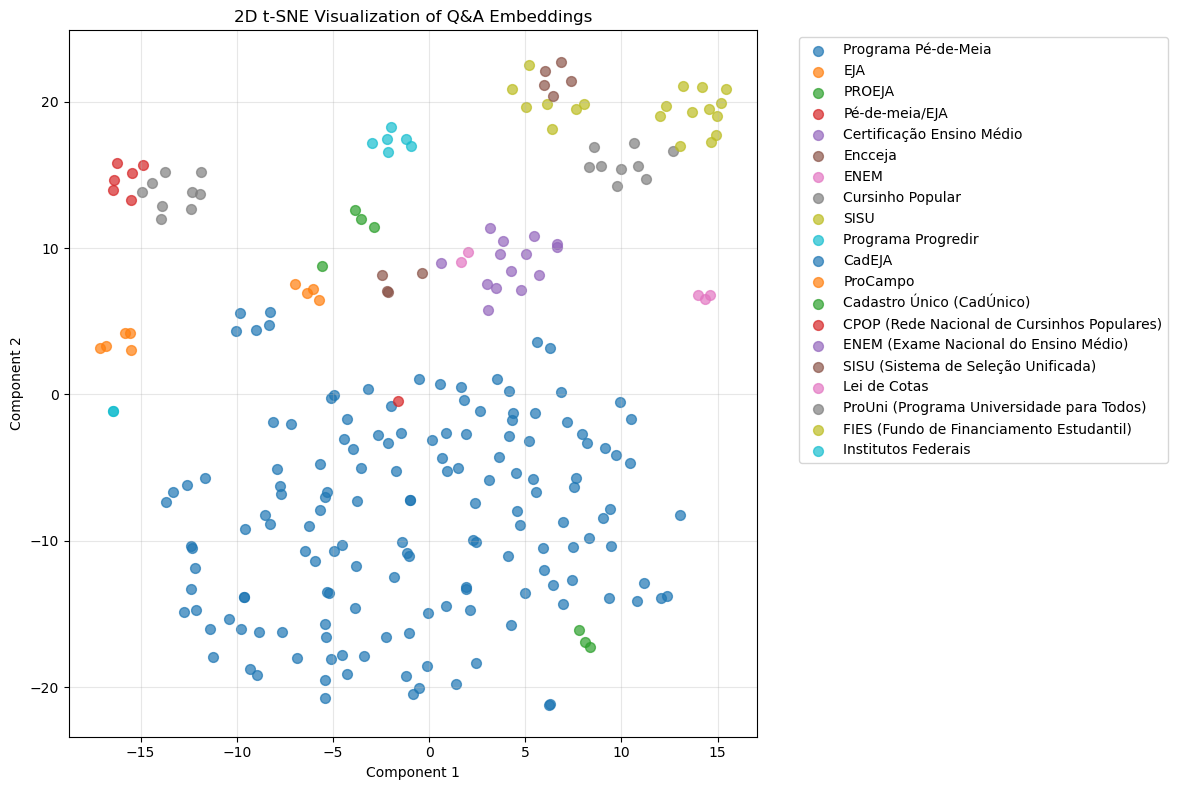

In [19]:
create_2d_plot(embeddings_2d_tsne, embeddings_df, '2D t-SNE Visualization of Q&A Embeddings')

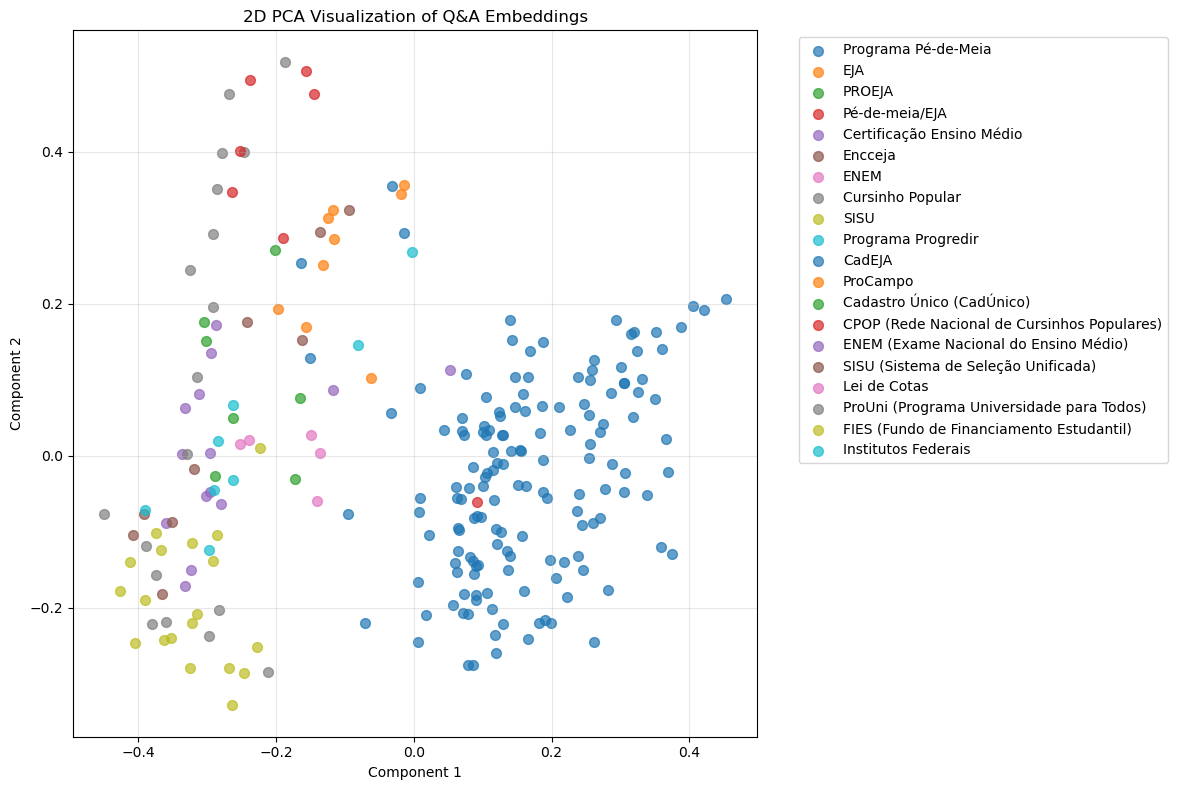

In [20]:
create_2d_plot(embeddings_2d_pca, embeddings_df, '2D PCA Visualization of Q&A Embeddings')

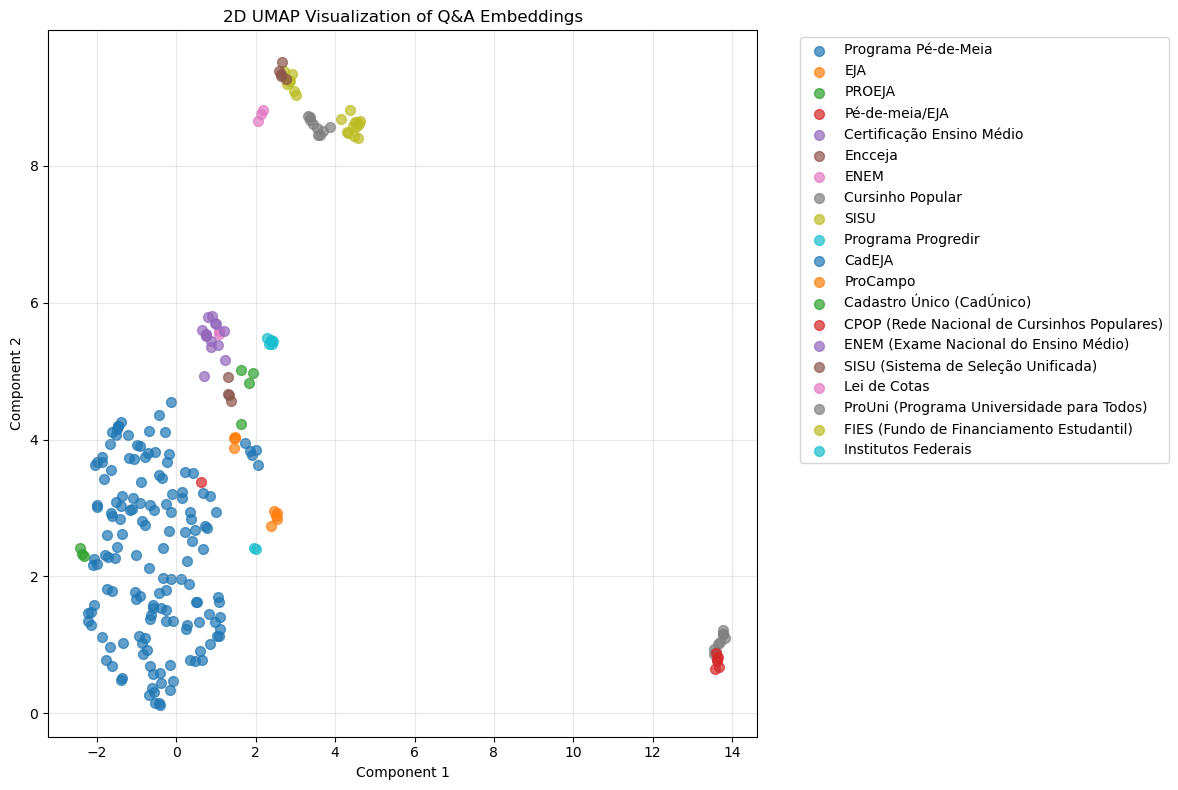

In [21]:
create_2d_plot(embeddings_2d_umap, embeddings_df, '2D UMAP Visualization of Q&A Embeddings')